# Exploration strategies #

During the following notebooks we will consider the selection of a task as a multi-armed bandit problem. An agent must choose among $N$ independent tasks, each task $a$ returns a reward of one with probability $p_a\in[0,1]$ and zero with probability $1-p_a$. These probabilities are unknown to the agent, that is trying to maximize the sum of rewards over $T$ time steps (or alternatively to minimize regret). Since the agent has no initial knowledge about the reward distributions, it should gather information about what tasks could provide the highest expected reward. The agent must balance information and reward gathering in some manner. This is known as the exploration-exploitation dilemma. In this notebook we compare various exploration strategies.

In [7]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import multivariate_normal
from matplotlib.ticker import MaxNLocator

A very simple scenario is assumed where the reward distribution of each task is fixed and randomly sampled from a uniform distribution.

In [8]:
# Randomly sample from a uniform distribution and assign each task a probability of giving a reward
def initArms(numBandits):
    return np.random.random(size=numBandits)

# For plotting the evolution of the accumulated rewards
def plotRew(rew, steps):
    ax = plt.figure(figsize=(12,9)).gca()
    labels = ['Random','Greedy','$\epsilon$-greedy','TS','UCB']
    colors = ['blue','red','black','orange','brown']
    for r in range(len(rew)):
        ax.plot(rew[r], '-', markersize=8, color=colors[r], alpha=0.5, label=labels[r], linewidth=2.5)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.ylabel('Cumulative reward')
    plt.xlabel('Time steps')
    plt.xlim(0, steps)
    plt.show()

### Random ###
As the name indicates, this strategy selects a task randomly roughly in equal proportion. This strategy is used as baseline to compare the rest.

In [9]:
def random(counts):
    # Get number of bandits
    numBandits = counts.shape[0]
    return np.random.randint(0,numBandits)

### Greedy and $\epsilon$-greedy ###
A greedy strategy is a purely exploitative in the sense that it always selects the task with the highest expected reward given the current information. Although a greedy agent may select different actions during its lifetime, the strategy makes no explicit attempt of exploring them and may select suboptimal actions indefinitely.

$\epsilon$-greedy on the other hand acts greedily with a probability $1-\epsilon$ (exploitation) and randomly with probability $\epsilon$ (exploration). Accordingly a greedy strategy can be considered as $\epsilon$-greedy with $\epsilon=0$.

$$
a_t =
  \begin{cases}
   \arg\max_{a} \hat{Q}(a) & \text{with probability } 1-\epsilon \\
   random       & \text{with probability } \epsilon
  \end{cases}
$$

Where $\hat{Q}(a)$ is $\mu_a$ or $\mathbb{E}[R_a]$.

In [10]:
def eGreedy(counts, epsilon=0.1):
    # Get number of bandits
    numBandits = counts.shape[0]
    # Select random choice
    if np.random.random() < epsilon:
        action = np.random.randint(0, numBandits)
    # Or act greedily
    else:
        action = np.argmax(counts[:,2])
    return action

### Upper Confidence Bounds ###

The Upper Confidence Bounds (UCB) algorithm is based on the Chernoff-Hoeffding inequality which is given by:
    
$$
P(\mu - \mathbb{E}[\mu] > u) \leq e^{-2Nu^2}
$$

The expression provides a probability for an upper bound $u$ for which the empirical mean $\mu$ deviates from the theoretical mean $\mathbb{E}[\mu]$. The right side of the expression intuitively tells us that as the number $N$ of measurements increase, our estimate of $\mu$ becomes more accurate and consequently the probability of deviating by $u$ decreases.

UCB applies this principle to the rewards of the bandit so the inequality is reformulated as $P(\hat{Q}(a) - Q(a) > u) \leq e^{-2Nu^2}$. Thus we can state as $p=e^{-2Nu^2}$ the probability that our estimation $\hat{Q}(a)$ exceeds $u$. A probability $p=t^{-4}$ is used to reduce it as we gather more observations and ensuring optimal action selection as $t\rightarrow\infty$ which leads to a confidence bound given by:

$$
u = \sqrt{\frac{2logt}{N}}
$$

For the multi-armed bandit problem, we can associate $u(a)$ to the specific confidence bound for arm or task $a$. In that case $N$ corresponds to $N_a$ which is the number of times task $a$ has been selected by an agent and $t$ the time steps at a given moment. The selection of a task will be given by:

$$
a_t = \arg\max_{a} [\hat{Q}(a) + u(a)]
$$

UCB provides an adaptive way to explore the task space since the selection of the task is not only given by our current estimation $\hat{Q}(a)$ of the reward (exploitation) but also from our confidence $u(a)$ about the estimate (exploration). An agent starts with large confidence bounds or uncertainty about the tasks because the corresponding $N_a$ is low for all of them. As a task $a$ is continuosly selected $N_a$ becomes larger and consequently $u(a)$ decreases. This means that the agent is more certain about its estimation of $\hat{Q}(a)$ as its contribution has a much larger weight in the decision making process. However, since the confidence bounds also depend on $logt$ this ensures that the agent explores because $u(a)$ continues growing slowly for those tasks that have not been selected as frequently. 

In some treatments an additional hyperparameter $c$ is used to control the contribution of the confidence bound. For our examples we set $c=1$.

In [17]:
def UCB1(counts, step):
    # Get number of bandits
    numBandits = counts.shape[0]
    # Tunable hyperparameter
    c = 1
    # Store upper confidence bounds
    ucbs = []
    for i in range(numBandits):
        # Get number of times the bandit has been selected (at least once since they've been initialized)
        N = np.sum(counts[i,[0,1]])
        # Get mean(t-1) success for this arm (#success / #times arm has been played)
        mu = counts[i,0] / N
        # Calculate UCB
        # UCB_i(t) = mu_i(t-1) + c * sqrt[2 log t / N_i(t-1)]
        ucb = mu + (c * np.sqrt( (2*np.log(step+1)) / N ))
        ucbs.append(ucb)
    action = np.argmax(ucbs)
    return action

### Thompson Sampling ###

Thompson Sampling (TS) or posterior sampling is a Bayesian strategy for action selection. TS keeps track of the probability distributions of the rewards and selects a task according to the probability that it is optimal, thus TS is said to be $\textit{probability matching}$. The distribution reflects the confidence about our beliefs regarding the outcome we can obtain from the task. Therefore the selection of a task will depend on how likely it is to obtain a positive outcome as well as how certain we are about our estimation. Since the agent samples from the posterior distributions the balance between exploration and exploitation is handled seamlessly.

The expression below shows how the current estimation of receiving a reward in task $a$, $\theta_a$, depends on the prior beliefs about it and the likelihood of the observations given our beliefs on $\theta_a$:

$$
\underbrace{P(\theta_a|\textbf{x}_a)}_\text{posterior} \propto \underbrace{P(\textbf{x}_a|\theta_a)}_\text{likelihood} \times \underbrace{P(\theta_a)}_\text{prior}
$$

For our current example, we could start with an uniformative prior $Beta(\alpha,\beta)$ with parameters $\alpha=1$ for the number of times we received a reward and $\beta=1$ when we did not. This is equivalent to a Uniform distribution bounded between 0 an 1, but it will make manipulating the distributions more convenient. 

In the case of the likelihood, if we consider the outcomes as independent Bernoulli events they can be denoted by $P(\textbf{x}_a|\theta_a) = \theta_a^k (1-\theta_a^k)^{N-k}$  where $k$ is the number of times the agent received a reward in a given task $a$.

In order to obtain the posterior we use the fact that the Beta prior is conjugate to the Bernoulli likelihood. So our posterior will also be a Beta distribution:

$$
P(\theta_a|\textbf{x}_a) = Beta(\alpha=\alpha_0 + k, \beta=\beta_0 + N - k)
$$

This simplifies our problem by reducing it to counting the number of occurrences. Then to decide what task to select we sample $\theta_a \sim P(\theta_a|\textbf{x}_a)$ from each task posterior distribution. As in previous strategies $\theta_a$ corresponds to our reward estimation $\hat{Q}(a)$ or the expected task reward $\mathbb{E}[R_a]$.

$$
a_t = \arg\max_{a} \hat{Q}(a)
$$

In [14]:
def thompsonSampling(counts):
    # Get number of bandits
    numBandits = counts.shape[0]
    # The prior is given by a beta distribution, so define prior on alpha and beta (i.e. Beta(a,B))
    # The bandits were initialized for now assuming the prior parameters are the same for all bandits
    alpha = 1
    beta = 1
    samples = []
    for i in range(numBandits):
        # Since it is conjugate we can just get the posterior with the counts and plug it into the distribution
        # Sample from the posterior p(reward|History)
        posterior = np.random.beta(counts[i][0] + alpha, counts[i][1] + beta)
        samples.append(posterior)
    action = np.argmax(samples)
    return action

In the plot below we can observe intuitively how the knowledge of the outcome of the tasks would be represented according to our observations. We start with the prior in dark blue which is uniform from 0 to 1. Let's suppose that after 98 observations of a certain task we obtained a reward in 49 of them, in that case the peak's distribution is centered at 0.5. Naturally this means that at this point we will be equally uncertain about whether we will receive a reward or not. On the other hand the green and turquoise distributions have very clear tendencies. For instance most of the density of the green distribution is very close to 1, therefore by selecting this task we have a very high expectation of getting a reward.

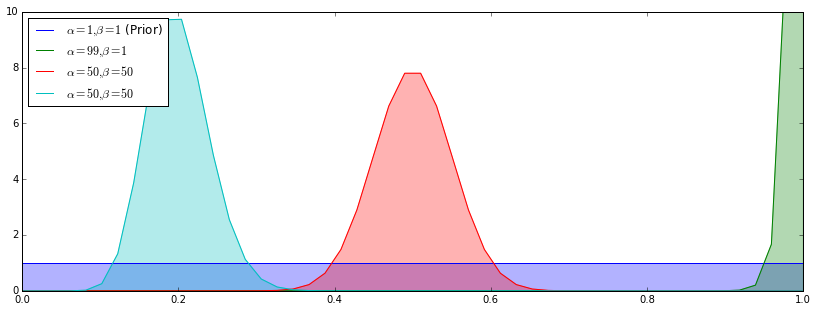

In [5]:
# Beta distribution with various parameters
figsize(14, 5)
plt.ylim(0,10)
x = np.linspace(0,1)
y1, y2, y3, y4 = stats.beta.pdf(x, 1, 1), stats.beta.pdf(x, 99, 1), stats.beta.pdf(x, 50, 50), stats.beta.pdf(x, 20, 80)

p = plt.plot(x, y1, label=r"$\alpha=1, \beta=1$ (Prior)")
plt.fill_between(x, 0, y1, color = p[0].get_color(), alpha = 0.3)
p = plt.plot(x, y2, label=r"$\alpha=99, \beta=1$")
plt.fill_between(x, 0, y2, color = p[0].get_color(), alpha = 0.3)
p = plt.plot(x, y3, label=r"$\alpha=50, \beta=50$")
plt.fill_between(x, 0, y3, color = p[0].get_color(), alpha = 0.3)
p = plt.plot(x, y4, label=r"$\alpha=50, \beta=50$")
plt.fill_between(x, 0, y4, color = p[0].get_color(), alpha = 0.3)

plt.legend(loc = "upper left")

In [15]:
def selectAction(counts, strategy, step):
    if strategy == 'random':
        action = random(counts)
    elif strategy == 'greedy':
        action = eGreedy(counts, epsilon=0)
    elif strategy == 'eGreedy':
        action = eGreedy(counts)
    elif strategy == 'ucb':
        action = UCB1(counts, step)
    elif strategy == 'thompson':
        action = thompsonSampling(counts)
    return action

# Based on the bandit that was selected see if you got the reward or you didn't
def observe(probs, action):
    pSuccess = probs[action]
    if np.random.random() < pSuccess:
        return 1
    else:
        return 0

def simulate(numBandits, probs, steps, strategy='greedy'):
    # Save total reward and action selected
    statistics = []
    totalReward = 0
    # Store observations about [successes, failures, prob of success]
    counts = np.ones((numBandits, 3))
    if strategy != 'ucb':
        # Accordingly, set initial probabilities of success with 0.5 for each bandit
        counts[:,2] = 0.5

    # UCB1 requires additional initialization
    if strategy == 'ucb':
        # It needs to play each of the arms once
        for arm in range(numBandits):
            # Execute action and observe reward
            reward = observe(probs, arm)
            totalReward += reward
            statistics.append([totalReward, arm])
            # Update successes and failures for the bandit [(succ, fail) so 1-reward]
            counts[arm, 1-reward] += 1
            # Update probability of success
            counts[arm, 2] = counts[arm, 0] / np.sum(counts[arm, [0,1]])

    for step in range(steps):
        # Apply policy to get an action
        action = selectAction(counts, strategy, step)
        # Execute action and observe reward
        reward = observe(probs, action)
        totalReward += reward
        statistics.append([totalReward, action])
        # Update successes and failures for the bandit [(succ, fail) so 1-reward]
        counts[action, 1-reward] += 1
        # Update probability of success
        counts[action, 2] = counts[action, 0] / np.sum(counts[action,[0,1]])

    return statistics

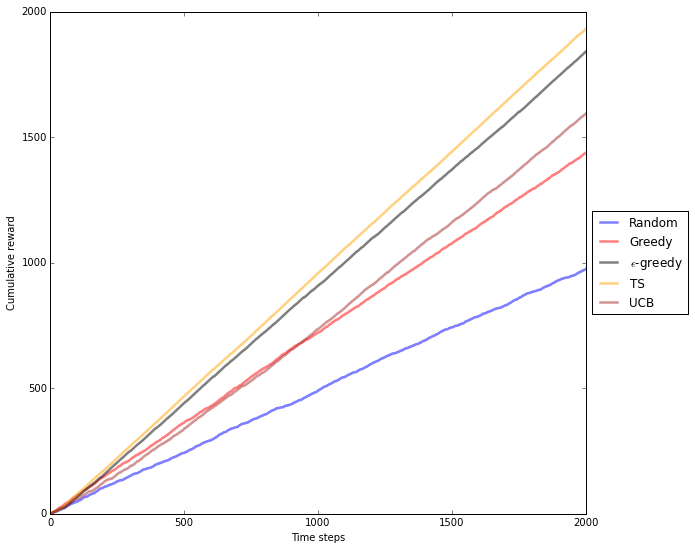

In [26]:
# Number of tasks
numBandits = 20
# Randomly generate probabilities of observing a reward
probs = initArms(numBandits)
# For how many steps to run the exercise?
steps = 2000

strategies = ['random','greedy','eGreedy','thompson','ucb']
rew = []
for strategy in strategies:
    stats = simulate(numBandits, probs, steps, strategy=strategy)
    rew.append(np.array(stats)[:,0])
plotRew(rew,steps)